# Getting Started with RasterFrames Notebook

## Setup Spark Environment

In [1]:
import pyrasterframes
import pyrasterframes.rf_ipython  # enables nicer visualizations of pandas DF
from pyrasterframes.rasterfunctions import (rf_local_add, rf_dimensions, rf_extent, rf_crs, rf_mk_crs,
                                            st_geometry, st_reproject, rf_tile)
import pyspark.sql.functions as F

In [2]:
spark = pyrasterframes.get_spark_session()

### Get a PySpark DataFrame from [open data](https://docs.opendata.aws/modis-pds/readme.html)

Read a single "granule" or scene of MODIS surface reflectance data. 

In [3]:
uri = 'https://modis-pds.s3.amazonaws.com/MCD43A4.006/11/08/2019059' \
      '/MCD43A4.A2019059.h11v08.006.2019072203257_B02.TIF'
df = spark.read.raster(uri)

In [4]:
df.printSchema()

root
 |-- proj_raster_path: string (nullable = false)
 |-- proj_raster: struct (nullable = true)
 |    |-- tile_context: struct (nullable = false)
 |    |    |-- extent: struct (nullable = false)
 |    |    |    |-- xmin: double (nullable = false)
 |    |    |    |-- ymin: double (nullable = false)
 |    |    |    |-- xmax: double (nullable = false)
 |    |    |    |-- ymax: double (nullable = false)
 |    |    |-- crs: struct (nullable = false)
 |    |    |    |-- crsProj4: string (nullable = false)
 |    |-- tile: tile (nullable = false)



Do some work with the raster data; add 3 element-wise to the pixel/cell values and show some rows of the DataFrame.

In [5]:
df.select(rf_local_add(df.proj_raster, F.lit(3))).show(5, False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|rf_local_add(proj_raster, 3)                                                                                                                                                                                                                                                                                                                                           |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

The extent struct tells us where in the [CRS](https://spatialreference.org/ref/sr-org/6842/) the tile data covers. The granule is split into arbitrary sized chunks. Each row is a different chunk. Let's see how many.

Side note: you can configure the default size of these chunks, which are called Tiles, by passing a tuple of desired columns and rows as: `raster(uri, tile_dimensions=(96, 96))`. The default is `(256, 256)`

In [6]:
df.count()

100

What area does the DataFrame cover?

In [7]:
crs = df.agg(F.first(rf_crs(df.proj_raster)).crsProj4.alias('crs')).first()['crs']
print(crs)
coverage_area = df.select(
                           df.proj_raster_path,
                           st_reproject(
                               st_geometry(rf_extent(df.proj_raster)), 
                               rf_mk_crs(crs), 
                               rf_mk_crs('EPSG:4326')).alias('footprint')
                         )
coverage_area.show(10, False)

+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs 
+--------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|proj_raster_path                                                                                              |footprint                                                                                                                                                                                                |
+--------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

So where in the world is that? We'll generate a little visualization with Leaflet in the notebook using Folium.

In [8]:
import geopandas
import folium

In [9]:
gdf = geopandas.GeoDataFrame(
        coverage_area.select('footprint').toPandas(), 
        geometry='footprint', crs={'init':'EPSG:4326'}) 

In [10]:
folium.Map((5, -65), zoom_start=6) \
    .add_child(folium.GeoJson(gdf.__geo_interface__))

Look at a sample of the data. You may find it useful to double-click the tile image column to see larger or smaller rendering of the image.

,proj_raster_path,extent,tile
0,https://modis-pds.s3.amazonaws.com/MCD43A4.006/11/08/2019059/MCD43A4.A2019059.h11v08.006.2019072203257_B02.TIF,"(-7783653.637667, 993342.4642358534, -7665045.582235852, 1111950.519667)",
1,https://modis-pds.s3.amazonaws.com/MCD43A4.006/11/08/2019059/MCD43A4.A2019059.h11v08.006.2019072203257_B02.TIF,"(-7665045.582235853, 993342.4642358534, -7546437.526804706, 1111950.519667)",
2,https://modis-pds.s3.amazonaws.com/MCD43A4.006/11/08/2019059/MCD43A4.A2019059.h11v08.006.2019072203257_B02.TIF,"(-7546437.526804707, 993342.4642358534, -7427829.471373559, 1111950.519667)",
3,https://modis-pds.s3.amazonaws.com/MCD43A4.006/11/08/2019059/MCD43A4.A2019059.h11v08.006.2019072203257_B02.TIF,"(-7427829.47137356, 993342.4642358534, -7309221.415942413, 1111950.519667)",
4,https://modis-pds.s3.amazonaws.com/MCD43A4.006/11/08/2019059/MCD43A4.A2019059.h11v08.006.2019072203257_B02.TIF,"(-7309221.415942414, 993342.4642358534, -7190613.360511266, 1111950.519667)",

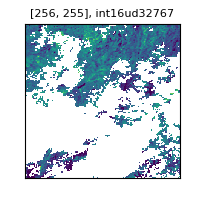
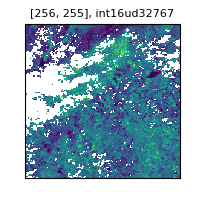
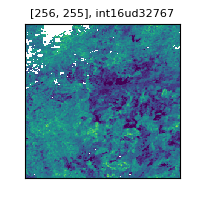
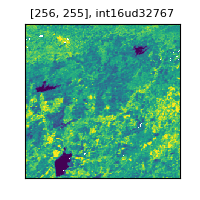
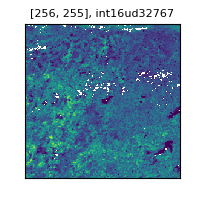

In [11]:
#Look at a sample
pandas_df = df.select(
    df.proj_raster_path,
    rf_extent(df.proj_raster).alias('extent'),
    rf_tile(df.proj_raster).alias('tile'),
).limit(5).toPandas()
pandas_df